# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
* Контролировать добросовестность кассиров при продаже алкоголя.

Цель - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# Загрузка библиотке
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Загрузка фотографий и возрастной разметки:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
# общий анализ
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Плотность и размах'),
 Text(0.5, 0, 'Возраст, лет'),
 (0.0, 111.26686921674023)]

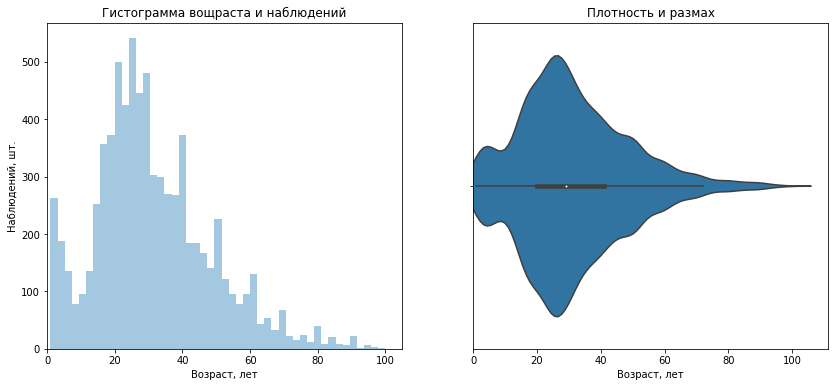

In [6]:
# построение гистограммы
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.distplot (labels['real_age'], ax=axes[0], bins='auto', kde=False)
axes[0].set (title='Гистограмма вощраста и наблюдений', xlabel='Возраст, лет', ylabel='Наблюдений, шт.', xlim=0);
sns.violinplot (data=labels, ax=axes[1], x='real_age')
axes[1].set (title='Плотность и размах', xlabel='Возраст, лет', xlim=0)

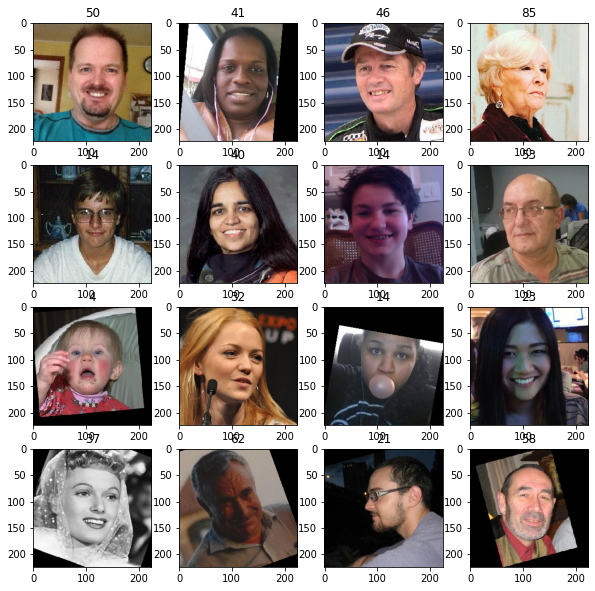

In [7]:
# оценка качества изображений
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])

**Вывод:**
1. Предоставлено 7591 цветное изображение с разметкой по возрасту. Пропуски не найдены.
2. Анализ данных показал, что в данных присутствуют значения от 1 года до 100 лет. Средний возраст в разметке равен 30 а диаграмма размаха простирается примерно до 70 лет. Возрастное распределение не вполне соответствует нормальному: в данных имеется очень большое количество детских фотографий по сровнению с фотографиями взрослых, гистограмма показала распределение со скосом вправо.
3. Обзор изображений в целом согласуется с разметкой возраста: присутствуют и младенцы, и пожилые люди. Есть разные условия освещенности и посторонние предметы, частично закрывающие лица. Часть изображений повернута на случайный угол.

## Обучение модели

Для обучения модели будет использоваться предобученная модель ResNet50.

Модель небходимо достроить:

- добавить слой GlobalAveragePooling2D;
- добавить слой Dropout;
- добавить полносвязный слой с одним выходным значением и активацией ReLU.

Также к обучающей выборке добавим:
- случайное горизонтальное отражение;
- случайное приближение;
- случайное искажение перспективы.
- повороты


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import pandas as pd
import numpy as np

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25, horizontal_flip=True,
                                       zoom_range=0.2, shear_range=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=177013)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=177013)

    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=5e-5)
    backbone = ResNet50(input_shape=input_shape, include_top=False,
                weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Целью проекта было построить модель, которая по фотографии определит приблизительный возраст человека. Мы подготовили данные, дополнили обучающую выборку с помощью аугментаций и достроили модель ResNet50 с помощью полносвязного слоя для регрессии.

По итогам 20 эпох обучения средняя абсолютная ошибка на тестовой выборке лежит в пределах 5 лет.

Фотофиксация в прикассовой зоне помогает определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
* Контролировать добросовестность кассиров при продаже алкоголя.

С учетом главной цели, полученные результаты - неплохие: интервалы возрастных групп обычно составляют порядка 10 лет. А вот для контроля совершеннолетия при продаже алкоголя такая погрешность едва ли приемлема. Однако есть возможность, что при попадании клиентов в нижние 2-3 группы, система будет запрашивать их удостоверения личности, чтобы подтвердить возраст.